BATTERY MANAGEMENT SYSTEM - ML PROJECT
Start Time: 2025-08-18 18:58:23.217020

1. Generating synthetic battery data...
Generated synthetic dataset with 800 records for 4 batteries

2. Performing data analysis...
BATTERY MANAGEMENT SYSTEM - DATA STATISTICS
Dataset Shape: (800, 9)
Number of Batteries: 4
Average Cycles per Battery: 200.0

Capacity Statistics:
  Initial Capacity (avg): 1.995 Ah
  Final Capacity (avg): 1.226 Ah
  Capacity Range: 1.030 - 2.114 Ah

Operating Conditions:
  Temperature Range: 11.6°C - 38.8°C
  Voltage Range: 3.58V - 4.04V
  Current Range: 1.01A - 2.00A

Battery Health Metrics:
  SOH Range: 50.2% - 100.0%
  Average RUL: 31.4 cycles


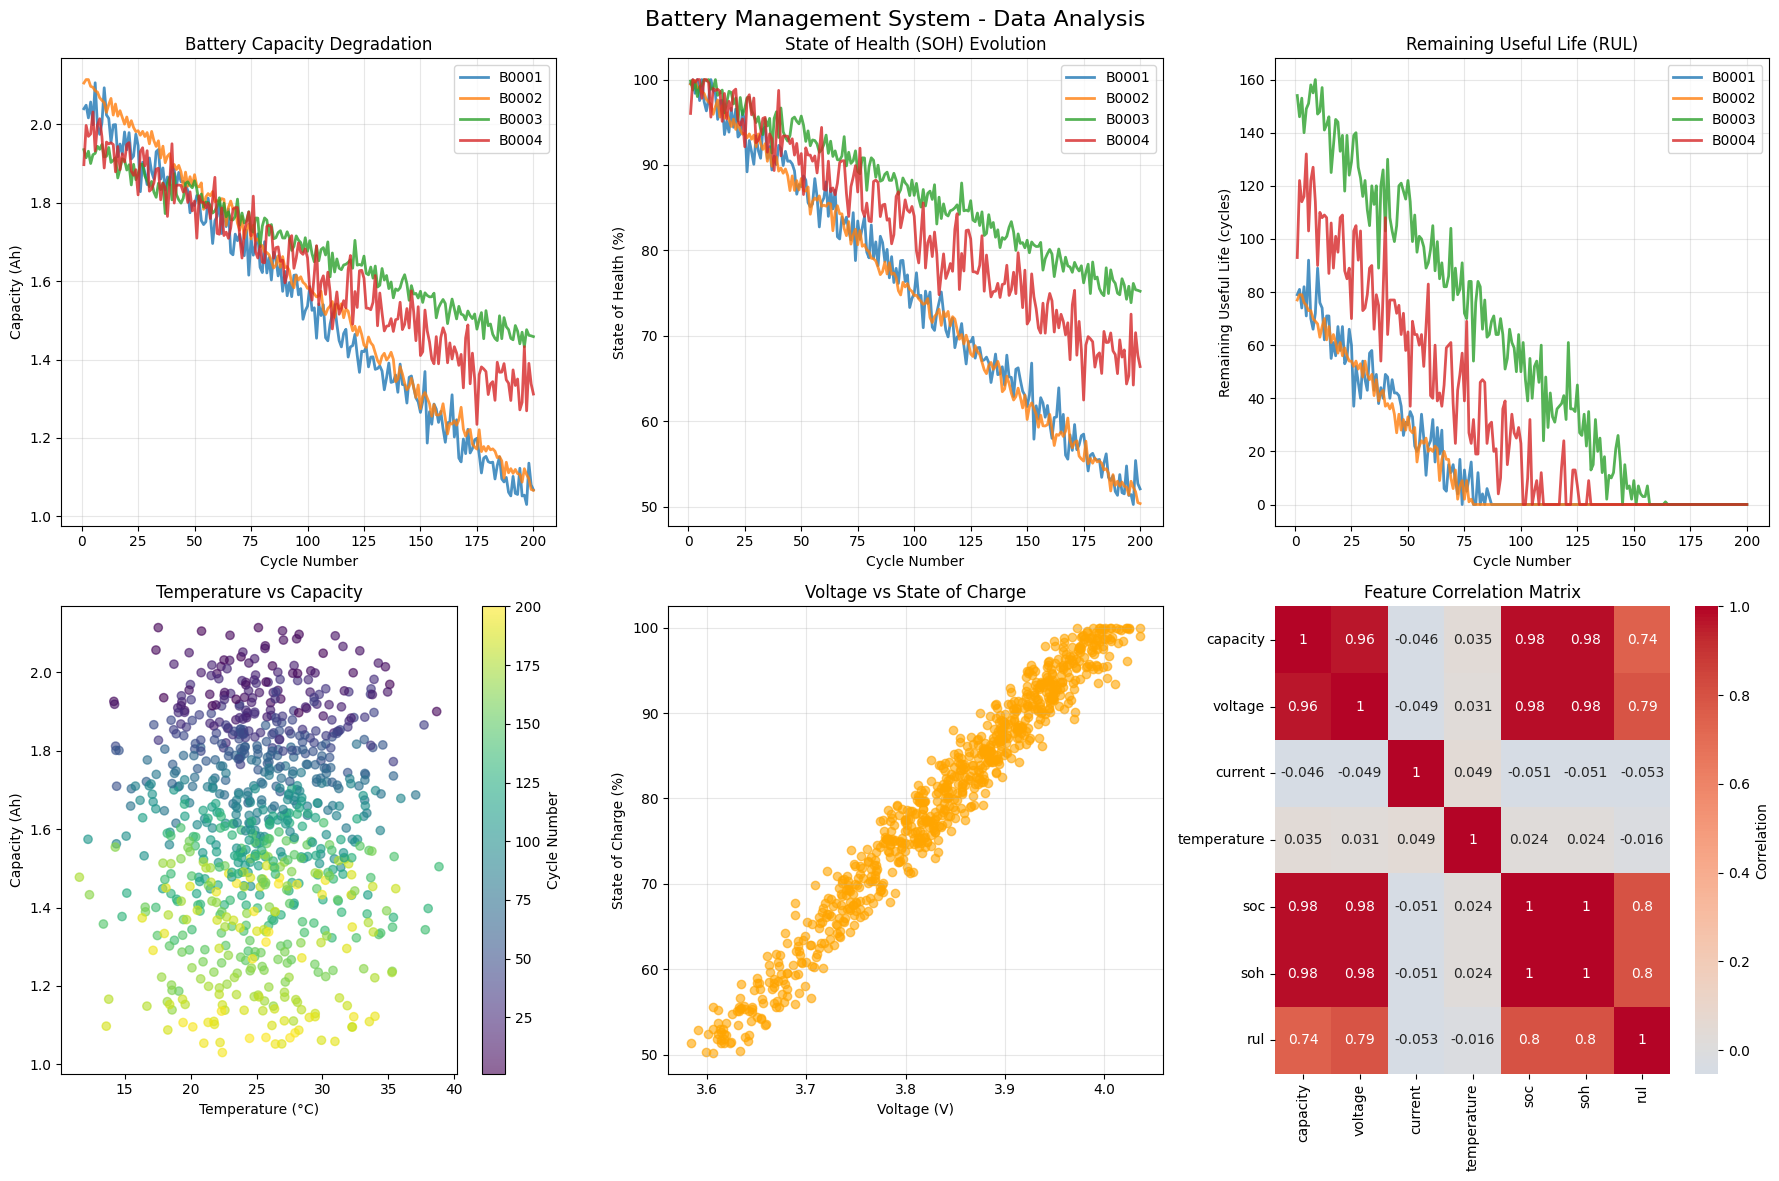


3. Engineering features...

4. Training traditional ML models...
Training Machine Learning Models...

Training models for SOC...
  Linear Regression: MAE=0.318, RMSE=0.410, R²=0.999
  Random Forest: MAE=0.317, RMSE=0.455, R²=0.999
  Neural Network: MAE=6.072, RMSE=7.849, R²=0.615

Training models for SOH...
  Linear Regression: MAE=0.318, RMSE=0.410, R²=0.999
  Random Forest: MAE=0.317, RMSE=0.455, R²=0.999
  Neural Network: MAE=6.072, RMSE=7.849, R²=0.615

Training models for RUL...
  Linear Regression: MAE=15.382, RMSE=18.932, R²=0.749
  Random Forest: MAE=3.151, RMSE=6.930, R²=0.966
  Neural Network: MAE=7.972, RMSE=12.783, R²=0.885

5. Training LSTM models...

Training LSTM Models...
LSTM data shape: X=(760, 10, 7), y_soc=(760,)

Training LSTM for SOC...


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 7 and 10 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_2, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,7], [10,200].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 7), dtype=float32)
  • states=('tf.Tensor(shape=(None, 50), dtype=float32)', 'tf.Tensor(shape=(None, 50), dtype=float32)')
  • training=True

In [1]:
# battery_management_system.py

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ------------------------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------------------------

# Dataset configuration
SEQUENCE_LENGTH = 10  # For LSTM models
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Model parameters
LSTM_EPOCHS = 20  # Reduced for faster execution
LSTM_BATCH_SIZE = 32
LSTM_UNITS = 50

# Visualization settings
plt.style.use('default')
FIGSIZE = (12, 8)

# ------------------------------------------------------------------------------
# 1. DATA GENERATION & PREPROCESSING
# ------------------------------------------------------------------------------

def generate_synthetic_battery_data(n_cycles=300, n_batteries=4):
    """Generate synthetic battery data similar to NASA dataset structure"""

    data = []

    for battery_id in range(1, n_batteries + 1):
        # Battery-specific parameters
        initial_capacity = np.random.normal(2.0, 0.1)  # Ah
        degradation_rate = np.random.uniform(0.001, 0.003)  # per cycle
        noise_level = np.random.uniform(0.01, 0.05)

        battery_data = []

        for cycle in range(1, n_cycles + 1):
            # Capacity degradation with some regeneration effects
            base_capacity = initial_capacity * (1 - degradation_rate * cycle)

            # Add capacity regeneration (occasional increases)
            if cycle > 50 and np.random.random() < 0.05:
                regeneration = np.random.uniform(0.01, 0.03)
                base_capacity += regeneration

            # Add realistic noise
            capacity = base_capacity + np.random.normal(0, noise_level)
            capacity = max(capacity, 0.5)  # Minimum capacity threshold

            # Temperature effects
            temperature = np.random.normal(25, 5)  # Celsius
            if temperature > 35:
                capacity *= 0.98  # High temp degradation
            elif temperature < 10:
                capacity *= 0.95  # Low temp degradation

            # Voltage simulation
            voltage = 3.2 + (capacity / initial_capacity) * 0.8 + np.random.normal(0, 0.02)

            # Current simulation
            current = np.random.uniform(1.0, 2.0)

            # Calculate SOC (simplified)
            soc = (capacity / initial_capacity) * 100
            soc = max(0, min(100, soc))  # Clamp between 0-100

            # Calculate SOH
            soh = capacity / initial_capacity * 100
            soh = max(0, min(100, soh))  # Clamp between 0-100

            # Calculate RUL (cycles until 80% capacity)
            eol_capacity = initial_capacity * 0.8
            if capacity > eol_capacity:
                rul = max(0, int((capacity - eol_capacity) / (degradation_rate * initial_capacity)))
            else:
                rul = 0

            battery_data.append({
                'battery_id': f'B{battery_id:04d}',
                'cycle': cycle,
                'capacity': capacity,
                'voltage': voltage,
                'current': current,
                'temperature': temperature,
                'soc': soc,
                'soh': soh,
                'rul': rul
            })

        data.extend(battery_data)

    df = pd.DataFrame(data)
    print(f"Generated synthetic dataset with {len(df)} records for {n_batteries} batteries")
    return df

# ------------------------------------------------------------------------------
# 2. EXPLORATORY DATA ANALYSIS
# ------------------------------------------------------------------------------

def visualize_battery_data(df):
    """Create comprehensive visualizations of battery data"""

    # Set up the plotting area
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Battery Management System - Data Analysis', fontsize=16)

    # 1. Capacity degradation over cycles
    ax1 = axes[0, 0]
    for battery in df['battery_id'].unique()[:4]:
        battery_data = df[df['battery_id'] == battery]
        ax1.plot(battery_data['cycle'], battery_data['capacity'],
                label=battery, alpha=0.8, linewidth=2)
    ax1.set_xlabel('Cycle Number')
    ax1.set_ylabel('Capacity (Ah)')
    ax1.set_title('Battery Capacity Degradation')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. SOH over time
    ax2 = axes[0, 1]
    for battery in df['battery_id'].unique()[:4]:
        battery_data = df[df['battery_id'] == battery]
        ax2.plot(battery_data['cycle'], battery_data['soh'],
                label=battery, alpha=0.8, linewidth=2)
    ax2.set_xlabel('Cycle Number')
    ax2.set_ylabel('State of Health (%)')
    ax2.set_title('State of Health (SOH) Evolution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. RUL prediction
    ax3 = axes[0, 2]
    for battery in df['battery_id'].unique()[:4]:
        battery_data = df[df['battery_id'] == battery]
        ax3.plot(battery_data['cycle'], battery_data['rul'],
                label=battery, alpha=0.8, linewidth=2)
    ax3.set_xlabel('Cycle Number')
    ax3.set_ylabel('Remaining Useful Life (cycles)')
    ax3.set_title('Remaining Useful Life (RUL)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Temperature vs Capacity
    ax4 = axes[1, 0]
    scatter = ax4.scatter(df['temperature'], df['capacity'],
                         c=df['cycle'], cmap='viridis', alpha=0.6)
    ax4.set_xlabel('Temperature (°C)')
    ax4.set_ylabel('Capacity (Ah)')
    ax4.set_title('Temperature vs Capacity')
    plt.colorbar(scatter, ax=ax4, label='Cycle Number')

    # 5. Voltage vs SOC
    ax5 = axes[1, 1]
    ax5.scatter(df['voltage'], df['soc'], alpha=0.6, c='orange')
    ax5.set_xlabel('Voltage (V)')
    ax5.set_ylabel('State of Charge (%)')
    ax5.set_title('Voltage vs State of Charge')
    ax5.grid(True, alpha=0.3)

    # 6. Feature correlation heatmap
    ax6 = axes[1, 2]
    correlation_matrix = df[['capacity', 'voltage', 'current', 'temperature',
                            'soc', 'soh', 'rul']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                ax=ax6, cbar_kws={'label': 'Correlation'})
    ax6.set_title('Feature Correlation Matrix')

    plt.tight_layout()
    plt.show()

def data_statistics(df):
    """Display comprehensive data statistics"""
    print("="*60)
    print("BATTERY MANAGEMENT SYSTEM - DATA STATISTICS")
    print("="*60)

    print(f"Dataset Shape: {df.shape}")
    print(f"Number of Batteries: {df['battery_id'].nunique()}")
    print(f"Average Cycles per Battery: {df.groupby('battery_id')['cycle'].max().mean():.1f}")

    print("\nCapacity Statistics:")
    print(f"  Initial Capacity (avg): {df.groupby('battery_id')['capacity'].first().mean():.3f} Ah")
    print(f"  Final Capacity (avg): {df.groupby('battery_id')['capacity'].last().mean():.3f} Ah")
    print(f"  Capacity Range: {df['capacity'].min():.3f} - {df['capacity'].max():.3f} Ah")

    print("\nOperating Conditions:")
    print(f"  Temperature Range: {df['temperature'].min():.1f}°C - {df['temperature'].max():.1f}°C")
    print(f"  Voltage Range: {df['voltage'].min():.2f}V - {df['voltage'].max():.2f}V")
    print(f"  Current Range: {df['current'].min():.2f}A - {df['current'].max():.2f}A")

    print("\nBattery Health Metrics:")
    print(f"  SOH Range: {df['soh'].min():.1f}% - {df['soh'].max():.1f}%")
    print(f"  Average RUL: {df['rul'].mean():.1f} cycles")

# ------------------------------------------------------------------------------
# 3. FEATURE ENGINEERING (FIXED)
# ------------------------------------------------------------------------------

def create_features(df):
    """Create additional features for ML models"""

    df_features = df.copy()

    # Sort by battery and cycle
    df_features = df_features.sort_values(['battery_id', 'cycle']).reset_index(drop=True)

    # Initialize new columns
    df_features['capacity_rolling_mean'] = 0.0
    df_features['capacity_change'] = 0.0
    df_features['cumulative_loss'] = 0.0
    df_features['voltage_degradation'] = 0.0

    # Rolling statistics (per battery)
    for battery in df_features['battery_id'].unique():
        mask = df_features['battery_id'] == battery
        battery_data = df_features[mask].copy()

        # Rolling mean capacity (last 5 cycles)
        rolling_mean = battery_data['capacity'].rolling(window=5, min_periods=1).mean()
        df_features.loc[mask, 'capacity_rolling_mean'] = rolling_mean.values

        # Capacity change rate
        capacity_change = battery_data['capacity'].diff().fillna(0)
        df_features.loc[mask, 'capacity_change'] = capacity_change.values

        # Cumulative capacity loss
        initial_capacity = battery_data['capacity'].iloc[0]
        cumulative_loss = initial_capacity - battery_data['capacity']
        df_features.loc[mask, 'cumulative_loss'] = cumulative_loss.values

        # Voltage degradation
        initial_voltage = battery_data['voltage'].iloc[0]
        voltage_degradation = initial_voltage - battery_data['voltage']
        df_features.loc[mask, 'voltage_degradation'] = voltage_degradation.values

    # Cycle-based features
    df_features['cycle_normalized'] = df_features['cycle'] / df_features['cycle'].max()

    # Temperature categories
    df_features['temp_category'] = pd.cut(df_features['temperature'],
                                         bins=[-np.inf, 15, 35, np.inf],
                                         labels=[0, 1, 2])
    df_features['temp_category'] = df_features['temp_category'].astype(int)

    return df_features

# ------------------------------------------------------------------------------
# 4. MACHINE LEARNING MODELS
# ------------------------------------------------------------------------------

def train_models(df):
    """Train multiple ML models for SOC, SOH, and RUL prediction"""

    print("Training Machine Learning Models...")

    # Prepare features
    feature_cols = ['capacity', 'voltage', 'current', 'temperature',
                   'capacity_rolling_mean', 'capacity_change', 'cycle_normalized',
                   'temp_category', 'cumulative_loss', 'voltage_degradation']

    X = df[feature_cols]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    results = {}

    # Train models for each target
    targets = ['soc', 'soh', 'rul']

    for target in targets:
        print(f"\nTraining models for {target.upper()}...")

        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
        )

        # Traditional ML models
        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE),
            'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 25),
                                         max_iter=200, random_state=RANDOM_STATE)
        }

        target_results = {}

        for name, model in models.items():
            # Train model
            model.fit(X_train, y_train)

            # Predictions
            y_pred = model.predict(X_test)

            # Metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            target_results[name] = {
                'model': model,
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'r2': r2,
                'y_test': y_test,
                'y_pred': y_pred
            }

            print(f"  {name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")

        results[target] = target_results

    return results, scaler

# ------------------------------------------------------------------------------
# 5. LSTM DEEP LEARNING MODEL
# ------------------------------------------------------------------------------

def prepare_lstm_data(df, sequence_length=10):
    """Prepare data for LSTM model"""

    X, y_soc, y_soh, y_rul = [], [], [], []

    # Feature columns for LSTM
    feature_cols = ['capacity', 'voltage', 'current', 'temperature',
                   'capacity_rolling_mean', 'capacity_change', 'cycle_normalized']

    for battery in df['battery_id'].unique():
        battery_data = df[df['battery_id'] == battery].sort_values('cycle')

        if len(battery_data) < sequence_length + 1:
            continue

        # Normalize features
        scaler = MinMaxScaler()
        features = scaler.fit_transform(battery_data[feature_cols])

        # Create sequences
        for i in range(len(features) - sequence_length):
            X.append(features[i:(i + sequence_length)])
            y_soc.append(battery_data.iloc[i + sequence_length]['soc'])
            y_soh.append(battery_data.iloc[i + sequence_length]['soh'])
            y_rul.append(battery_data.iloc[i + sequence_length]['rul'])

    return np.array(X), np.array(y_soc), np.array(y_soh), np.array(y_rul)

def build_lstm_model(input_shape, output_dim=1):
    """Build LSTM model for battery prediction"""

    model = Sequential([
        LSTM(LSTM_UNITS, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(LSTM_UNITS//2, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(output_dim)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])

    return model

def train_lstm_models(df):
    """Train LSTM models for time series prediction"""

    print("\nTraining LSTM Models...")

    # Prepare LSTM data
    X, y_soc, y_soh, y_rul = prepare_lstm_data(df, SEQUENCE_LENGTH)

    if len(X) == 0:
        print("Not enough data for LSTM training")
        return {}

    print(f"LSTM data shape: X={X.shape}, y_soc={y_soc.shape}")

    # Split data
    split_idx = int(len(X) * (1 - TEST_SIZE))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_soc_train, y_soc_test = y_soc[:split_idx], y_soc[split_idx:]
    y_soh_train, y_soh_test = y_soh[:split_idx], y_soh[split_idx:]
    y_rul_train, y_rul_test = y_rul[:split_idx], y_rul[split_idx:]

    lstm_results = {}

    # Train LSTM for each target
    targets = [('soc', y_soc_train, y_soc_test),
               ('soh', y_soh_train, y_soh_test),
               ('rul', y_rul_train, y_rul_test)]

    for target_name, y_train, y_test in targets:
        print(f"\nTraining LSTM for {target_name.upper()}...")

        # Build model
        model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[1]))

        # Train model
        history = model.fit(X_train, y_train,
                           batch_size=LSTM_BATCH_SIZE,
                           epochs=LSTM_EPOCHS,
                           validation_split=0.2,
                           verbose=0)

        # Predictions
        y_pred = model.predict(X_test, verbose=0)

        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        lstm_results[target_name] = {
            'model': model,
            'history': history,
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'r2': r2,
            'y_test': y_test,
            'y_pred': y_pred.flatten()
        }

        print(f"  LSTM {target_name.upper()}: MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")

    return lstm_results

# ------------------------------------------------------------------------------
# 6. EVALUATION & VISUALIZATION
# ------------------------------------------------------------------------------

def plot_model_results(results, lstm_results):
    """Plot comparison of all model results"""

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('Battery Management System - Model Performance', fontsize=16)

    targets = ['soc', 'soh', 'rul']
    target_labels = ['State of Charge (%)', 'State of Health (%)', 'Remaining Useful Life (cycles)']

    for i, (target, label) in enumerate(zip(targets, target_labels)):

        # 1. Model performance comparison (bar plot)
        ax1 = axes[i, 0]
        model_names = list(results[target].keys())
        r2_scores = [results[target][name]['r2'] for name in model_names]

        if target in lstm_results:
            model_names.append('LSTM')
            r2_scores.append(lstm_results[target]['r2'])

        colors = ['skyblue', 'lightgreen', 'orange', 'red'][:len(model_names)]
        bars = ax1.bar(model_names, r2_scores, color=colors)
        ax1.set_title(f'{target.upper()} - Model R² Comparison')
        ax1.set_ylabel('R² Score')
        ax1.set_ylim(0, 1)
        ax1.tick_params(axis='x', rotation=45)

        # Add value labels on bars
        for bar, score in zip(bars, r2_scores):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom')

        # 2. Best model predictions vs actual
        ax2 = axes[i, 1]
        best_model_name = max(results[target].keys(),
                             key=lambda x: results[target][x]['r2'])
        best_traditional = results[target][best_model_name]

        ax2.scatter(best_traditional['y_test'], best_traditional['y_pred'],
                   alpha=0.6, label=f'{best_model_name}')

        if target in lstm_results:
            ax2.scatter(lstm_results[target]['y_test'], lstm_results[target]['y_pred'],
                       alpha=0.6, label='LSTM', color='red')

        # Perfect prediction line
        min_val = min(best_traditional['y_test'])
        max_val = max(best_traditional['y_test'])
        ax2.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect')

        ax2.set_xlabel(f'Actual {label}')
        ax2.set_ylabel(f'Predicted {label}')
        ax2.set_title(f'{target.upper()} - Predictions vs Actual')
        ax2.legend()

    plt.tight_layout()
    plt.show()

def create_performance_summary(results, lstm_results):
    """Create a comprehensive performance summary table"""

    print("\n" + "="*80)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*80)

    targets = ['soc', 'soh', 'rul']
    target_names = ['State of Charge', 'State of Health', 'Remaining Useful Life']

    for target, target_name in zip(targets, target_names):
        print(f"\n{target_name.upper()} PREDICTION:")
        print("-" * 50)

        # Traditional models
        for model_name in results[target].keys():
            metrics = results[target][model_name]
            print(f"{model_name:20} | MAE: {metrics['mae']:6.3f} | RMSE: {metrics['rmse']:6.3f} | R²: {metrics['r2']:6.3f}")

        # LSTM model
        if target in lstm_results:
            lstm_metrics = lstm_results[target]
            print(f"{'LSTM':20} | MAE: {lstm_metrics['mae']:6.3f} | RMSE: {lstm_metrics['rmse']:6.3f} | R²: {lstm_metrics['r2']:6.3f}")

# ------------------------------------------------------------------------------
# 7. REAL-TIME BATTERY MONITORING DEMO
# ------------------------------------------------------------------------------

def battery_monitoring_demo(df, results, scaler):
    """Demonstrate real-time battery monitoring"""

    print("\n" + "="*60)
    print("REAL-TIME BATTERY MONITORING DEMO")
    print("="*60)

    # Select a random battery for demo
    demo_battery = np.random.choice(df['battery_id'].unique())
    battery_data = df[df['battery_id'] == demo_battery].sort_values('cycle')

    print(f"Monitoring Battery: {demo_battery}")

    # Get the best models
    best_soc_model = max(results['soc'].keys(), key=lambda x: results['soc'][x]['r2'])
    best_soh_model = max(results['soh'].keys(), key=lambda x: results['soh'][x]['r2'])
    best_rul_model = max(results['rul'].keys(), key=lambda x: results['rul'][x]['r2'])

    print(f"Best SOC Model: {best_soc_model}")
    print(f"Best SOH Model: {best_soh_model}")
    print(f"Best RUL Model: {best_rul_model}")

    # Simulate real-time monitoring for last 5 cycles
    recent_data = battery_data.tail(5)

    print("\nReal-time Predictions:")
    print("Cycle | Actual SOC | Pred SOC | Actual SOH | Pred SOH | Actual RUL | Pred RUL")
    print("-" * 75)

    feature_cols = ['capacity', 'voltage', 'current', 'temperature',
                   'capacity_rolling_mean', 'capacity_change', 'cycle_normalized',
                   'temp_category', 'cumulative_loss', 'voltage_degradation']

    for _, row in recent_data.iterrows():
        # Prepare features
        features = scaler.transform([row[feature_cols]])

        # Predictions
        soc_pred = results['soc'][best_soc_model]['model'].predict(features)[0]
        soh_pred = results['soh'][best_soh_model]['model'].predict(features)
        rul_pred = results['rul'][best_rul_model]['model'].predict(features)

        print(f"{row['cycle']:5d} | {row['soc']:8.1f} | {soc_pred:8.1f} | "
              f"{row['soh']:8.1f} | {soh_pred:8.1f} | {row['rul']:8.0f} | {rul_pred:8.0f}")

# ------------------------------------------------------------------------------
# 8. MAIN EXECUTION PIPELINE
# ------------------------------------------------------------------------------

def main():
    """Execute the complete battery management system pipeline"""

    print("="*60)
    print("BATTERY MANAGEMENT SYSTEM - ML PROJECT")
    print("="*60)
    print(f"Start Time: {datetime.now()}")

    # 1. Generate/Load Data
    print("\n1. Generating synthetic battery data...")
    df = generate_synthetic_battery_data(n_cycles=200, n_batteries=4)

    # 2. Data Analysis
    print("\n2. Performing data analysis...")
    data_statistics(df)
    visualize_battery_data(df)

    # 3. Feature Engineering
    print("\n3. Engineering features...")
    df_features = create_features(df)

    # 4. Train Traditional ML Models
    print("\n4. Training traditional ML models...")
    results, scaler = train_models(df_features)

    # 5. Train LSTM Models
    print("\n5. Training LSTM models...")
    lstm_results = train_lstm_models(df_features)

    # 6. Evaluate Results
    print("\n6. Evaluating and visualizing results...")
    plot_model_results(results, lstm_results)
    create_performance_summary(results, lstm_results)

    # 7. Real-time Demo
    print("\n7. Real-time monitoring demonstration...")
    battery_monitoring_demo(df_features, results, scaler)

    print(f"\nProject completed at: {datetime.now()}")
    print("="*60)

if __name__ == "__main__":
    main()


In [2]:
# battery_management_system_corrected.py

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# -------------------------------------------------------------------------------
# CONFIGURATION
# -------------------------------------------------------------------------------
SEQUENCE_LENGTH = 10  # For LSTM models
TEST_SIZE = 0.2
RANDOM_STATE = 42
LSTM_EPOCHS = 20  # Reduced for faster execution
LSTM_BATCH_SIZE = 32
LSTM_UNITS = 50

plt.style.use('default')
FIGSIZE = (12, 8)

# -------------------------------------------------------------------------------
# 1. DATA GENERATION & PREPROCESSING
# -------------------------------------------------------------------------------
def generate_synthetic_battery_data(n_cycles=300, n_batteries=4):
    """Generate synthetic battery data similar to NASA dataset structure"""
    data = []
    for battery_id in range(1, n_batteries + 1):
        initial_capacity = np.random.normal(2.0, 0.1)  # Ah
        degradation_rate = np.random.uniform(0.001, 0.003)
        noise_level = np.random.uniform(0.01, 0.05)
        for cycle in range(1, n_cycles + 1):
            base_capacity = initial_capacity * (1 - degradation_rate * cycle)
            if cycle > 50 and np.random.random() < 0.05:
                base_capacity += np.random.uniform(0.01, 0.03)
            capacity = max(base_capacity + np.random.normal(0, noise_level), 0.5)
            temperature = np.random.normal(25, 5)
            if temperature > 35:
                capacity *= 0.98
            elif temperature < 10:
                capacity *= 0.95
            voltage = 3.2 + (capacity / initial_capacity) * 0.8 + np.random.normal(0, 0.02)
            current = np.random.uniform(1.0, 2.0)
            soc = np.clip((capacity / initial_capacity) * 100, 0, 100)
            soh = soc
            eol_capacity = initial_capacity * 0.8
            rul = int(max(0, (capacity - eol_capacity) / (degradation_rate * initial_capacity))) if capacity > eol_capacity else 0

            data.append({
                'battery_id': f'B{battery_id:04d}',
                'cycle': cycle,
                'capacity': capacity,
                'voltage': voltage,
                'current': current,
                'temperature': temperature,
                'soc': soc,
                'soh': soh,
                'rul': rul
            })
    df = pd.DataFrame(data)
    print(f"Generated synthetic dataset with {len(df)} records for {n_batteries} batteries")
    return df

# -------------------------------------------------------------------------------
# 2. FEATURE ENGINEERING
# -------------------------------------------------------------------------------
def create_features(df):
    df = df.sort_values(['battery_id', 'cycle']).reset_index(drop=True)
    df['capacity_rolling_mean'] = df.groupby('battery_id')['capacity'].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)
    df['capacity_change'] = df.groupby('battery_id')['capacity'].diff().fillna(0)
    df['cumulative_loss'] = df.groupby('battery_id').apply(lambda x: x['capacity'].iloc[0] - x['capacity']).reset_index(level=0, drop=True)
    df['voltage_degradation'] = df.groupby('battery_id').apply(lambda x: x['voltage'].iloc[0] - x['voltage']).reset_index(level=0, drop=True)
    df['cycle_normalized'] = df['cycle'] / df['cycle'].max()
    df['temp_category'] = pd.cut(df['temperature'], bins=[-np.inf, 15, 35, np.inf], labels=[0, 1, 2]).astype(int)
    return df

# -------------------------------------------------------------------------------
# 3. PREPARE LSTM DATA
# -------------------------------------------------------------------------------
def prepare_lstm_data(df, sequence_length=SEQUENCE_LENGTH):
    feature_cols = ['capacity', 'voltage', 'current', 'temperature',
                    'capacity_rolling_mean', 'capacity_change', 'cycle_normalized']
    X, y_soc, y_soh, y_rul = [], [], [], []
    for battery in df['battery_id'].unique():
        data = df[df['battery_id'] == battery].sort_values('cycle')
        if len(data) < sequence_length + 1:
            continue
        scaler = MinMaxScaler()
        features = scaler.fit_transform(data[feature_cols])
        for i in range(len(features) - sequence_length):
            X.append(features[i:i+sequence_length])
            y_soc.append(data['soc'].iloc[i+sequence_length])
            y_soh.append(data['soh'].iloc[i+sequence_length])
            y_rul.append(data['rul'].iloc[i+sequence_length])
    return np.array(X), np.array(y_soc), np.array(y_soh), np.array(y_rul)

# -------------------------------------------------------------------------------
# 4. BUILD LSTM MODEL
# -------------------------------------------------------------------------------
def build_lstm_model(input_shape, output_dim=1):
    model = Sequential([
        LSTM(LSTM_UNITS, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(LSTM_UNITS // 2, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(output_dim)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# -------------------------------------------------------------------------------
# 5. TRAIN LSTM MODELS
# -------------------------------------------------------------------------------
def train_lstm_models(df):
    print("\nTraining LSTM Models...")
    X, y_soc, y_soh, y_rul = prepare_lstm_data(df)
    if len(X) == 0:
        print("Not enough data for LSTM training")
        return {}
    split = int(len(X) * (1 - TEST_SIZE))
    X_train, X_test = X[:split], X[split:]
    y_sets = {'soc': (y_soc[:split], y_soc[split:]),
              'soh': (y_soh[:split], y_soh[split:]),
              'rul': (y_rul[:split], y_rul[split:])}
    results = {}
    for target, (y_train, y_test) in y_sets.items():
        print(f"\nTraining LSTM for {target.upper()}...")
        model = build_lstm_model(input_shape=(SEQUENCE_LENGTH, X.shape[2]), output_dim=1)
        history = model.fit(X_train, y_train, batch_size=LSTM_BATCH_SIZE,
                            epochs=LSTM_EPOCHS, validation_split=0.2, verbose=0)
        y_pred = model.predict(X_test, verbose=0).flatten()
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        print(f" LSTM {target.upper()}: MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")
        results[target] = {
            'model': model, 'history': history,
            'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2,
            'y_test': y_test, 'y_pred': y_pred
        }
    return results

# -------------------------------------------------------------------------------
# 6. MAIN EXECUTION
# -------------------------------------------------------------------------------
def main():
    print("="*60)
    print("BATTERY MANAGEMENT SYSTEM - CORRECTED")
    print("="*60)
    print(f"Start Time: {datetime.now()}\n")

    # 1. Generate Data
    df = generate_synthetic_battery_data(n_cycles=200, n_batteries=4)

    # 2. Feature Engineering
    df_feat = create_features(df)

    # 3. Train LSTM Models
    lstm_results = train_lstm_models(df_feat)

    print(f"\nCompleted at: {datetime.now()}")
    print("="*60)

if __name__ == "__main__":
    main()


BATTERY MANAGEMENT SYSTEM - CORRECTED
Start Time: 2025-08-18 19:01:21.463994

Generated synthetic dataset with 800 records for 4 batteries

Training LSTM Models...

Training LSTM for SOC...
 LSTM SOC: MAE=7.827, RMSE=9.565, R²=-0.540

Training LSTM for SOH...
 LSTM SOH: MAE=29.079, RMSE=30.083, R²=-14.233

Training LSTM for RUL...


 LSTM RUL: MAE=5.282, RMSE=9.327, R²=0.817

Completed at: 2025-08-18 19:01:55.497885



========== BATTERY MANAGEMENT SYSTEM ==========
Start: 2025-08-18 19:04:58.803499
Generated 800 rows for 4 batteries

===== DATA STATISTICS =====
Shape: (800, 9)
Batteries: 4
Cycles per battery (avg): 200.0
Capacity range: 1.030–2.114 Ah
Voltage range: 3.58–4.04 V
Temperature range: 11.6–38.8 °C
SOH range: 50.2–100.0 %
Average RUL: 31.4 cycles


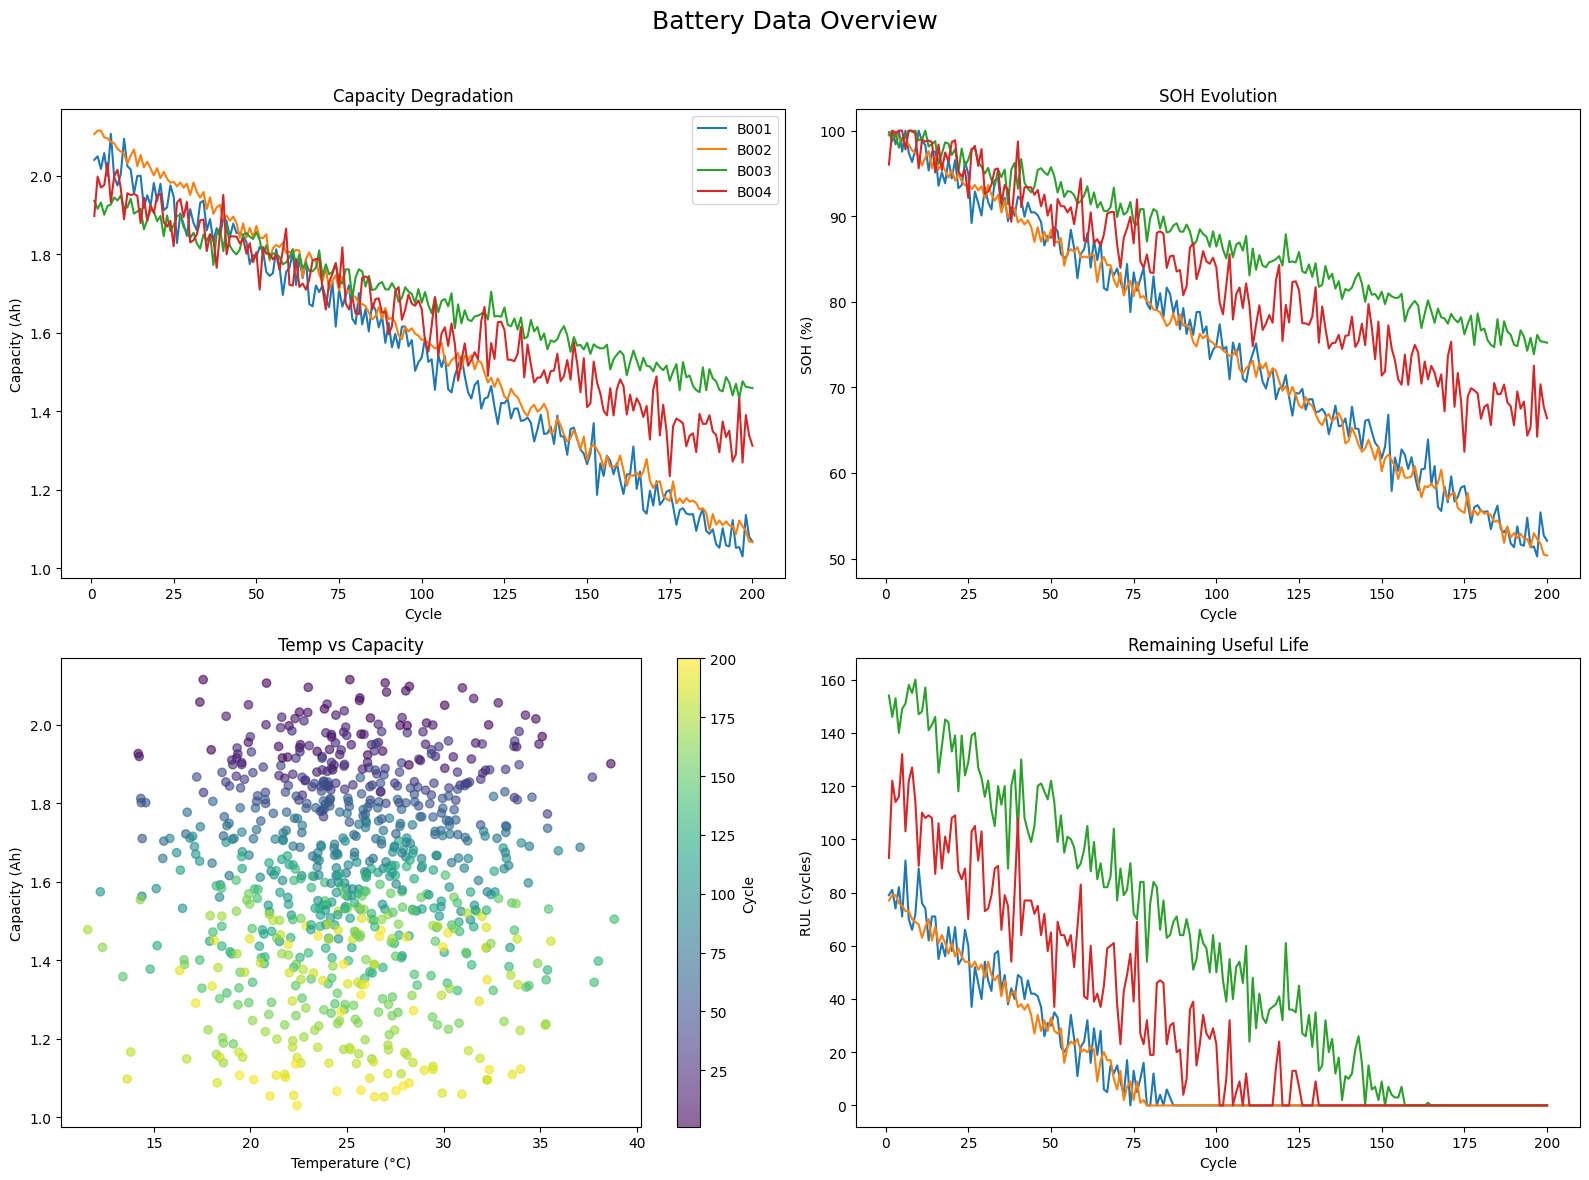

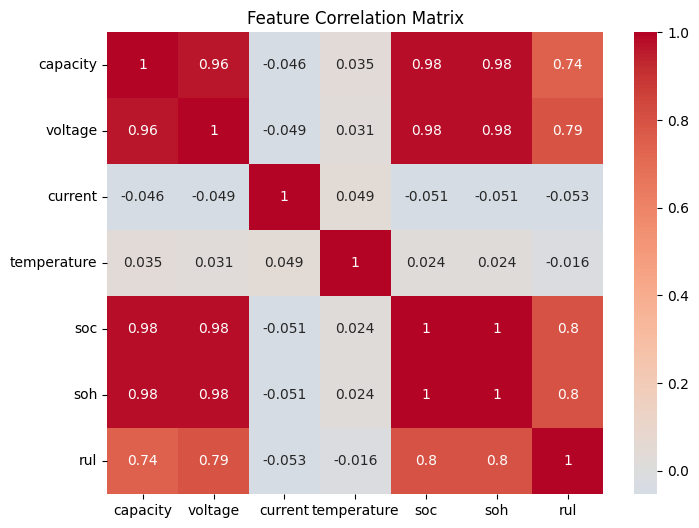

Training LSTM for SOC...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
Training LSTM for SOH...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Training LSTM for RUL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


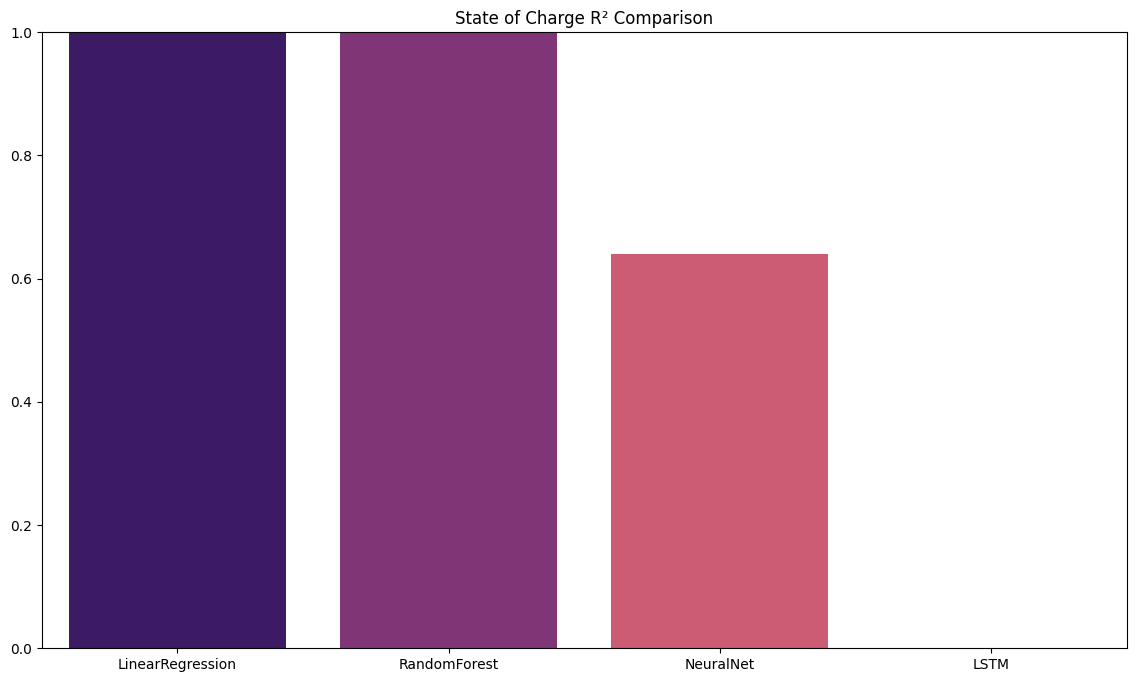

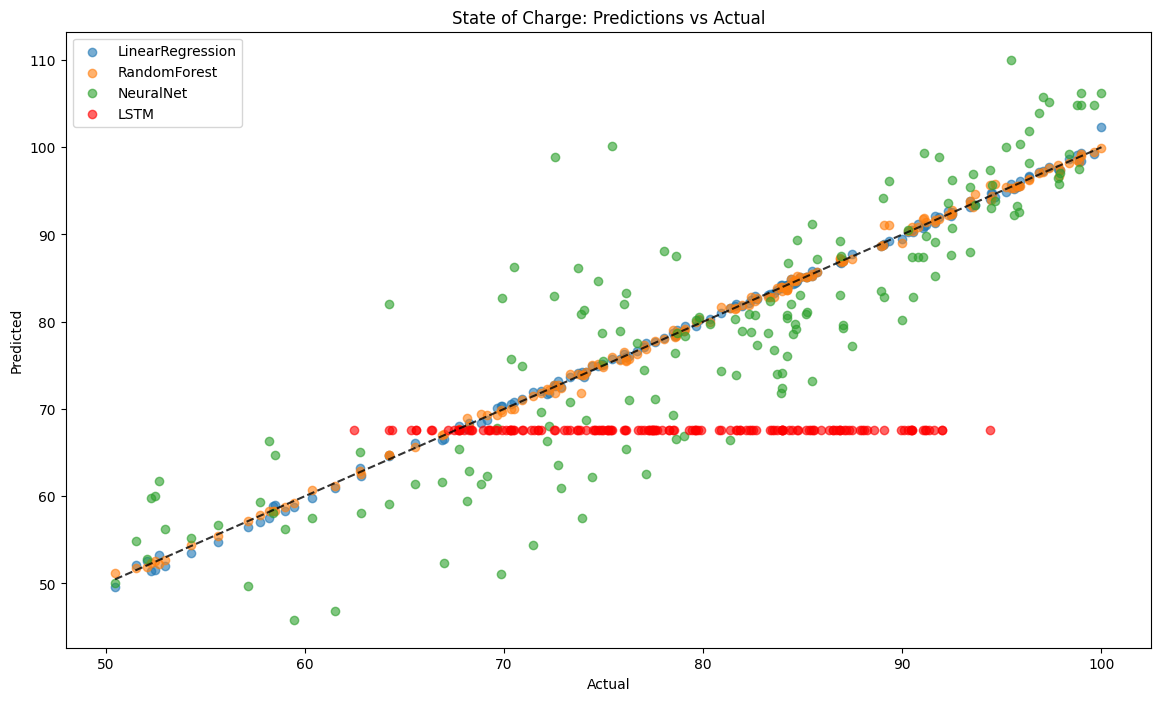

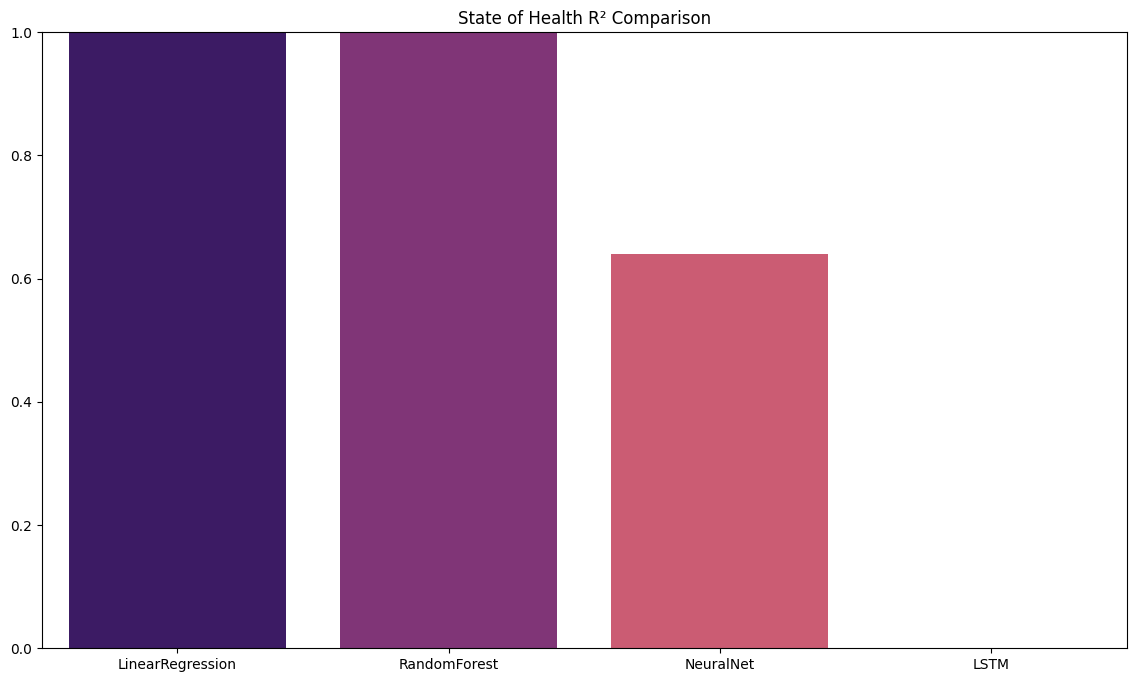

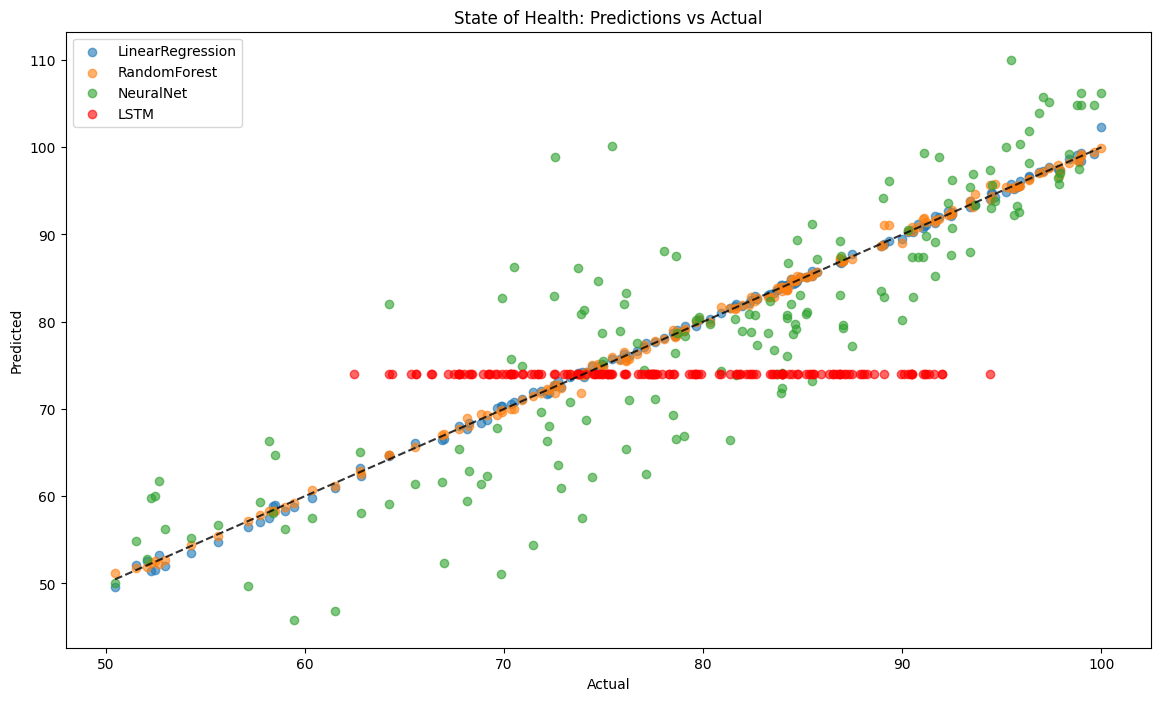

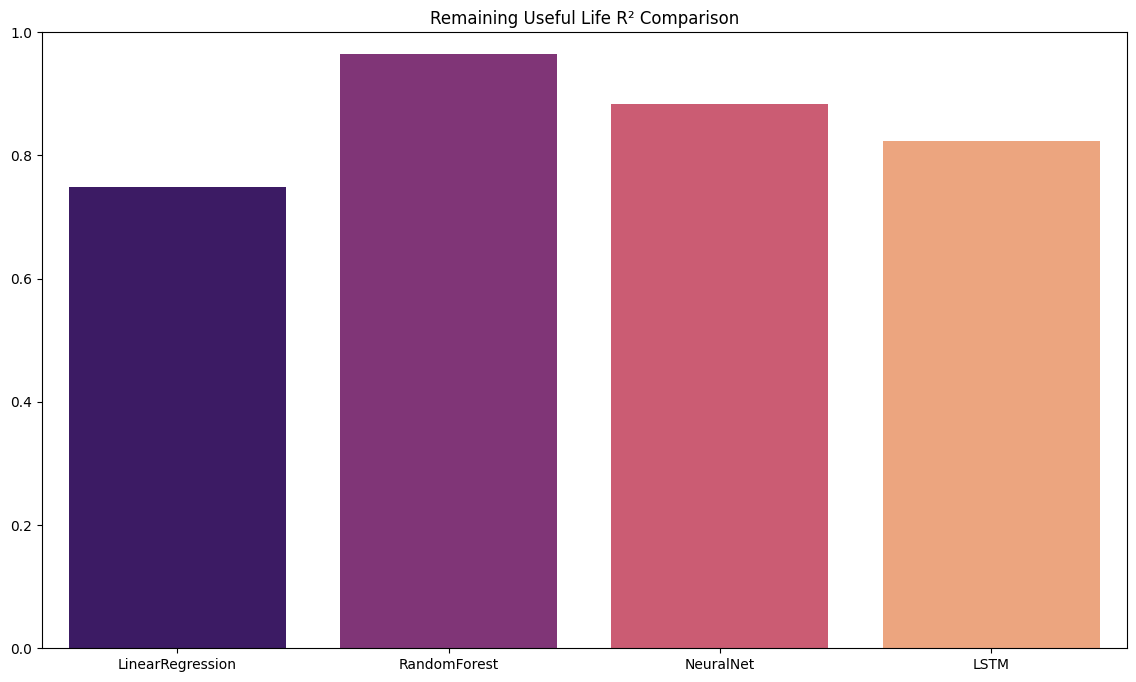

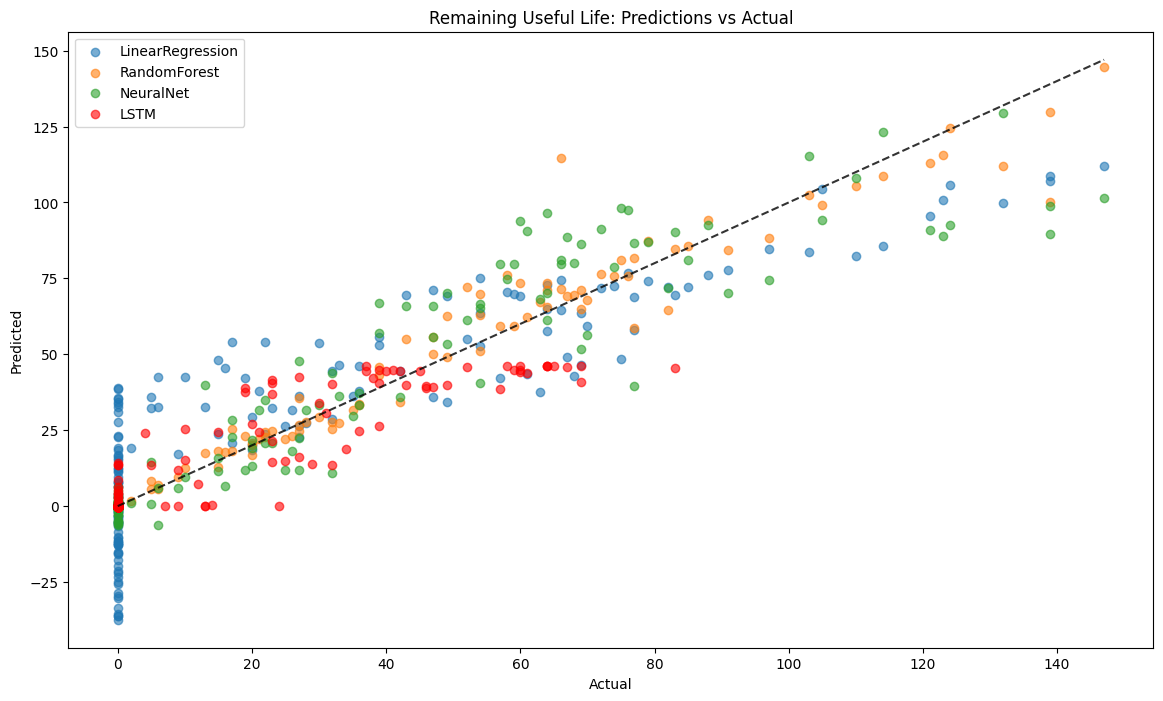


===== REAL-TIME MONITORING DEMO =====
Demo Battery: B001
Cycle | SOC_act | SOC_pred | SOH_act | SOH_pred | RUL_act | RUL_pred
  196 |    51.4 |     51.9 |    51.4 |     51.9 |       0 |        0
  197 |    50.2 |     50.8 |    50.2 |     50.8 |       0 |        0
  198 |    55.4 |     55.9 |    55.4 |     55.9 |       0 |        0
  199 |    52.7 |     53.2 |    52.7 |     53.2 |       0 |        0
  200 |    52.1 |     52.6 |    52.1 |     52.6 |       0 |        0

Completed: 2025-08-18 19:05:38.560915


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ----------------------------- Configuration -----------------------------
SEQUENCE_LENGTH   = 10
TEST_SIZE         = 0.2
RANDOM_STATE      = 42
LSTM_EPOCHS       = 20
LSTM_BATCH_SIZE   = 32
LSTM_UNITS        = 50
FIG_SIZE          = (14, 8)

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# ----------------------- 1. Data Generation -----------------------------
def generate_synthetic_battery_data(n_cycles=300, n_batteries=4):
    data = []
    for b in range(1, n_batteries + 1):
        init_cap    = np.random.normal(2.0, 0.1)
        deg_rate    = np.random.uniform(0.001, 0.003)
        noise_level = np.random.uniform(0.01, 0.05)
        for cycle in range(1, n_cycles + 1):
            base_cap = init_cap * (1 - deg_rate * cycle)
            if cycle > 50 and np.random.rand() < 0.05:
                base_cap += np.random.uniform(0.01, 0.03)
            cap = max(base_cap + np.random.normal(0, noise_level), 0.5)
            temp = np.random.normal(25, 5)
            cap *= 0.98 if temp > 35 else 0.95 if temp < 10 else 1.0
            volt    = 3.2 + (cap / init_cap) * 0.8 + np.random.normal(0, 0.02)
            curr    = np.random.uniform(1.0, 2.0)
            soc     = np.clip((cap / init_cap) * 100, 0, 100)
            soh     = soc
            eol_cap = init_cap * 0.8
            rul     = int(max(0, (cap - eol_cap) / (deg_rate * init_cap))) if cap > eol_cap else 0

            data.append({
                'battery_id': f'B{b:03d}',
                'cycle':      cycle,
                'capacity':   cap,
                'voltage':    volt,
                'current':    curr,
                'temperature':temp,
                'soc':        soc,
                'soh':        soh,
                'rul':        rul
            })
    df = pd.DataFrame(data)
    print(f"Generated {len(df)} rows for {n_batteries} batteries")
    return df

# ----------------------- 2. Exploratory Analysis ------------------------
def data_statistics(df):
    print("\n===== DATA STATISTICS =====")
    print(f"Shape: {df.shape}")
    print(f"Batteries: {df['battery_id'].nunique()}")
    print(f"Cycles per battery (avg): {df.groupby('battery_id')['cycle'].max().mean():.1f}")
    print(f"Capacity range: {df['capacity'].min():.3f}–{df['capacity'].max():.3f} Ah")
    print(f"Voltage range: {df['voltage'].min():.2f}–{df['voltage'].max():.2f} V")
    print(f"Temperature range: {df['temperature'].min():.1f}–{df['temperature'].max():.1f} °C")
    print(f"SOH range: {df['soh'].min():.1f}–{df['soh'].max():.1f} %")
    print(f"Average RUL: {df['rul'].mean():.1f} cycles")

def visualize_battery_data(df):
    plt.figure(figsize=(16, 12))
    plt.suptitle("Battery Data Overview", fontsize=18)

    # Capacity vs Cycle
    plt.subplot(2, 2, 1)
    for b in df['battery_id'].unique():
        tmp = df[df['battery_id']==b]
        plt.plot(tmp['cycle'], tmp['capacity'], label=b)
    plt.title("Capacity Degradation")
    plt.xlabel("Cycle")
    plt.ylabel("Capacity (Ah)")
    plt.legend()

    # SOH vs Cycle
    plt.subplot(2, 2, 2)
    for b in df['battery_id'].unique():
        tmp = df[df['battery_id']==b]
        plt.plot(tmp['cycle'], tmp['soh'], label=b)
    plt.title("SOH Evolution")
    plt.xlabel("Cycle")
    plt.ylabel("SOH (%)")

    # Temperature vs Capacity scatter
    plt.subplot(2, 2, 3)
    sc = plt.scatter(df['temperature'], df['capacity'], c=df['cycle'], cmap='viridis', alpha=0.6)
    plt.colorbar(sc, label="Cycle")
    plt.title("Temp vs Capacity")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Capacity (Ah)")

    # RUL vs Cycle
    plt.subplot(2, 2, 4)
    for b in df['battery_id'].unique():
        tmp = df[df['battery_id']==b]
        plt.plot(tmp['cycle'], tmp['rul'], label=b)
    plt.title("Remaining Useful Life")
    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")

    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(8,6))
    corr = df[['capacity','voltage','current','temperature','soc','soh','rul']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title("Feature Correlation Matrix")
    plt.show()

# ----------------------- 3. Feature Engineering ------------------------
def create_features(df):
    df = df.sort_values(['battery_id','cycle']).reset_index(drop=True)
    df['cap_roll_mean']    = df.groupby('battery_id')['capacity'].rolling(5, min_periods=1).mean().reset_index(0,drop=True)
    df['cap_change']       = df.groupby('battery_id')['capacity'].diff().fillna(0)
    df['cum_loss']         = df.groupby('battery_id').apply(lambda x: x['capacity'].iloc[0] - x['capacity']).reset_index(0,drop=True)
    df['volt_deg']         = df.groupby('battery_id').apply(lambda x: x['voltage'].iloc[0] - x['voltage']).reset_index(0,drop=True)
    df['cycle_norm']       = df['cycle'] / df['cycle'].max()
    df['temp_cat']         = pd.cut(df['temperature'], bins=[-np.inf,15,35,np.inf], labels=[0,1,2]).astype(int)
    return df

# ----------------------- 4. Traditional ML Models ----------------------
def train_traditional_models(df):
    features = ['capacity','voltage','current','temperature','cap_roll_mean','cap_change','cum_loss','volt_deg','cycle_norm','temp_cat']
    X = df[features]
    X_scaled = StandardScaler().fit_transform(X)
    results = {}
    for target in ['soc','soh','rul']:
        y = df[target]
        X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        models = {
            'LinearRegression': LinearRegression(),
            'RandomForest'     : RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE),
            'NeuralNet'        : MLPRegressor(hidden_layer_sizes=(50,25), max_iter=200, random_state=RANDOM_STATE)
        }
        res = {}
        for name, m in models.items():
            m.fit(X_tr, y_tr)
            pred = m.predict(X_te)
            mae = mean_absolute_error(y_te, pred)
            rmse= np.sqrt(mean_squared_error(y_te, pred))
            r2  = r2_score(y_te, pred)
            res[name] = {'model':m,'mae':mae,'rmse':rmse,'r2':r2,'y_test':y_te,'y_pred':pred}
        results[target] = res
    return results, StandardScaler().fit(X)

# ----------------------- 5. LSTM Modeling -----------------------------
def prepare_lstm_data(df):
    cols = ['capacity','voltage','current','temperature','cap_roll_mean','cap_change','cycle_norm']
    Xs, ys_soc, ys_soh, ys_rul = [],[],[],[]
    for b in df['battery_id'].unique():
        tmp = df[df['battery_id']==b].sort_values('cycle')
        if len(tmp) < SEQUENCE_LENGTH+1: continue
        scaler = MinMaxScaler()
        feats = scaler.fit_transform(tmp[cols])
        for i in range(len(feats)-SEQUENCE_LENGTH):
            Xs.append(feats[i:i+SEQUENCE_LENGTH])
            ys_soc.append(tmp['soc'].iloc[i+SEQUENCE_LENGTH])
            ys_soh.append(tmp['soh'].iloc[i+SEQUENCE_LENGTH])
            ys_rul.append(tmp['rul'].iloc[i+SEQUENCE_LENGTH])
    return np.array(Xs), np.array(ys_soc), np.array(ys_soh), np.array(ys_rul)

def build_lstm(input_shape):
    model = Sequential([
        LSTM(LSTM_UNITS, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(LSTM_UNITS//2),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
    return model

def train_lstm(df):
    X, y_soc, y_soh, y_rul = prepare_lstm_data(df)
    if len(X)==0:
        print("Insufficient data for LSTM"); return {}
    split = int(len(X)*(1-TEST_SIZE))
    X_tr, X_te = X[:split], X[split:]
    sets = {'soc':(y_soc[:split],y_soc[split:]),
            'soh':(y_soh[:split],y_soh[split:]),
            'rul':(y_rul[:split],y_rul[split:])}
    res = {}
    for tgt,(yt,yt_) in sets.items():
        print(f"Training LSTM for {tgt.upper()}...")
        m = build_lstm((SEQUENCE_LENGTH, X.shape[2]))
        hist = m.fit(X_tr, yt, epochs=LSTM_EPOCHS, batch_size=LSTM_BATCH_SIZE,
                     validation_split=0.2, verbose=0)
        pred = m.predict(X_te).flatten()
        mae  = mean_absolute_error(yt_, pred)
        rmse = np.sqrt(mean_squared_error(yt_, pred))
        r2   = r2_score(yt_, pred)
        res[tgt] = {'model':m,'history':hist,'mae':mae,'rmse':rmse,'r2':r2,'y_test':yt_,'y_pred':pred}
    return res

# ----------------------- 6. Performance Visualization ------------------
def plot_performance(trad, lstm_res):
    targets = {'soc':'State of Charge','soh':'State of Health','rul':'Remaining Useful Life'}
    for tgt,name in targets.items():
        plt.figure(figsize=FIG_SIZE)
        # R2 bar chart
        methods = list(trad[tgt].keys()) + (['LSTM'] if tgt in lstm_res else [])
        scores  = [trad[tgt][m]['r2'] for m in trad[tgt]] + ([lstm_res[tgt]['r2']] if tgt in lstm_res else [])
        sns.barplot(x=methods, y=scores, palette='magma')
        plt.ylim(0,1)
        plt.title(f"{name} R² Comparison")
        plt.show()

        # Predictions vs Actual
        plt.figure(figsize=FIG_SIZE)
        for m in trad[tgt]:
            plt.scatter(trad[tgt][m]['y_test'], trad[tgt][m]['y_pred'], alpha=0.6, label=m)
        if tgt in lstm_res:
            plt.scatter(lstm_res[tgt]['y_test'], lstm_res[tgt]['y_pred'], alpha=0.6, label='LSTM', color='red')
        mn = min(min(trad[tgt][m]['y_test']) for m in trad[tgt])
        mx = max(max(trad[tgt][m]['y_test']) for m in trad[tgt])
        plt.plot([mn,mx],[mn,mx],'k--',alpha=0.8)
        plt.title(f"{name}: Predictions vs Actual")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.legend()
        plt.show()

# ----------------------- 7. Real-time Monitoring Demo ------------------
def monitoring_demo(df, trad, scaler):
    print("\n===== REAL-TIME MONITORING DEMO =====")
    demo_batt = df['battery_id'].sample(1).iloc[0]
    bat_df = df[df['battery_id']==demo_batt].sort_values('cycle').tail(5)
    print(f"Demo Battery: {demo_batt}")
    best = {t:max(trad[t], key=lambda x:trad[t][x]['r2']) for t in trad}
    features = ['capacity','voltage','current','temperature','cap_roll_mean','cap_change','cum_loss','volt_deg','cycle_norm','temp_cat']
    print("Cycle | SOC_act | SOC_pred | SOH_act | SOH_pred | RUL_act | RUL_pred")
    for _,row in bat_df.iterrows():
        Xr = scaler.transform([row[features]])
        soc_p = trad['soc'][best['soc']]['model'].predict(Xr)[0]
        soh_p = trad['soh'][best['soh']]['model'].predict(Xr)[0]
        rul_p = trad['rul'][best['rul']]['model'].predict(Xr)[0]
        print(f"{int(row['cycle']):5d} | {row['soc']:7.1f} | {soc_p:8.1f} | {row['soh']:7.1f} | {soh_p:8.1f} | {int(row['rul']):7d} | {int(rul_p):8d}")

# ----------------------- 8. Main Pipeline -------------------------------
def main():
    print("\n========== BATTERY MANAGEMENT SYSTEM ==========")
    print(f"Start: {datetime.now()}")
    # Data
    df = generate_synthetic_battery_data(n_cycles=200, n_batteries=4)
    data_statistics(df)
    visualize_battery_data(df)
    # Features
    df_feat = create_features(df)
    # Traditional ML
    trad_res, scaler = train_traditional_models(df_feat)
    # LSTM
    lstm_res = train_lstm(df_feat)
    # Performance
    plot_performance(trad_res, lstm_res)
    monitoring_demo(df_feat, trad_res, scaler)
    print(f"\nCompleted: {datetime.now()}")
    print("==============================================")

if __name__ == "__main__":
    main()
